# Pipeline from image to emotion detecion and facial landmark identification

## Set Up

In [1]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [2]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Connect git repo to access data
!git clone https://github.com/valentin-brekke/emotion_artistic_augmentation.git

Cloning into 'emotion_artistic_augmentation'...
remote: Enumerating objects: 40978, done.
remote: Counting objects: 100% (6919/6919), done.
remote: Compressing objects: 100% (6915/6915), done.
remote: Total 40978 (delta 2), reused 6919 (delta 2), pack-reused 34059
Receiving objects: 100% (40978/40978), 280.28 MiB | 23.67 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (42796/42796), done.


## Utils

### Functions take photo

In [ ]:
from IPython.display import display, Javascript
from PIL import Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  display(Image.open(filename))
  print(f"Photo saved as {filename}")
  return filename

### Functions for face detection

In [ ]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualized.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width , bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    # for keypoint in detection.keypoints:
    #   keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
    #                                                  width, height)
    #   color, thickness, radius = (0, 255, 0), 2, 2
    #   cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = 'Face' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

In [ ]:
!wget -q -O detector.tflite -q https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

In [ ]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

def face_detector(filename='photo.jpg'):

    # STEP 1: Create an FaceDetector object.
    base_options = python.BaseOptions(model_asset_path='detector.tflite')
    options = vision.FaceDetectorOptions(base_options=base_options)
    detector = vision.FaceDetector.create_from_options(options)

    # STEP 2: Load the input image.
    image = mp.Image.create_from_file(filename)

    # STEP 3: Detect faces in the input image.
    detection_result = detector.detect(image)

    return image.numpy_view(), detection_result

def visualize_face_detector(image, detection):

    #image_copy = np.copy(image.numpy_view())
    annotated_image = visualize(image, detection)
    rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    cv2_imshow(rgb_annotated_image)


def crop(image, detection_result) -> np.ndarray:
    """Crops image to the bounding box and return it
    Args:
      image: The input RGB image.
      detection_result: The list of all "Detection" entities to be visualized.
    Returns:
      Cropped image to bounding box.
    """
    cropped_image = image.copy()
    height, width, _ = image.shape

    for detection in detection_result.detections:
      # Draw bounding_box
      bbox = detection.bounding_box
      start_point = bbox.origin_x, bbox.origin_y
      end_point = bbox.origin_x + bbox.width , bbox.origin_y + bbox.height
      x_margin = bbox.width
      cropped_image = cropped_image[bbox.origin_y: bbox.origin_y + bbox.height,
                                  bbox.origin_x: bbox.origin_x + bbox.width,
                                  :]

    return cropped_image

### Functions for emotion models

In [ ]:
import torch
from torch import nn

class CustomAdvancedCNN(nn.Module):
    def __init__(self):
        super(CustomAdvancedCNN, self).__init__()

        self.features = nn.Sequential(
            # first convolutional layer
            nn.Conv2d(1, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # second convolutional layer
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # third convolutional layer
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # fourth convolutional layer
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # fifth convolutional block
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 7),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
from torchvision import datasets, transforms
from PIL import Image
from transformers import pipeline
transformer_pipeline = pipeline("image-classification", model="dima806/facial_emotions_image_detection")

def predict_emotion(crop_image, model = 'ViT'):

    emotions_class = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    if model == 'CNN':
        model = CustomAdvancedCNN()
        model.load_state_dict(torch.load("emotion_artistic_augmentation/models/model_weights.pth", map_location=torch.device('cpu')))
        model.eval();
        # Define transformations
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((48, 48)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        # Make the croped image grayscale
        gray_img = cv2.cvtColor(crop_image, cv2.COLOR_RGB2GRAY)

        # To Pil format
        pilImage = Image.fromarray(gray_img)

        # Apply transformation
        tensor_img = transform(pilImage)
        tensor_img = tensor_img.unsqueeze(0)

        with torch.no_grad():
          output = model(tensor_img)
        predicted_emotion = torch.argmax(output, dim=1).item()

        emotion = emotions_class[predicted_emotion]
        print("Detected emotion: ", emotion)

    if model == 'ViT':

        gray_img = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
        pilImage = Image.fromarray(gray_img)
        results = transformer_pipeline(pilImage)

        emotion = results[0]['label']
        print("Detected emotion: ", emotion)

        predicted_emotion = emotions_class.index(emotion)

    else:
        return f'No model called {model}'

    return predicted_emotion


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

### Functions for style transfer

In [ ]:
import tensorflow as tf
import keras.preprocessing.image as process_im
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

In [ ]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.LANCZOS)
    im_array = np.expand_dims(image,axis=0)
    return im_array

def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]


  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

def get_model():

    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

In [ ]:
### Loss functions

def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)

    content_output=model(content_img)
    style_output=model(style_image)

    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature

def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    output=model(image)
    content_loss=0
    style_loss=0

    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]

    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)


    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)

    style_loss *= style_weight
    content_loss *= content_weight

    total_loss = content_loss + style_loss


    return total_loss,style_loss,content_loss

def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)

    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [ ]:
def run_style_transfer(content_path,style_path,epochs=500, content_weight=1e3, style_weight=1e-2):

    model=get_model()

    for layer in model.layers:
        layer.trainable = False

    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]

    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    best_loss,best_img=float('inf'),None

    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)

        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())

         #for visualization

        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))
            print('Total loss: {:.4e}, '
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))

    IPython.display.clear_output(wait=True)


    return best_img,best_loss,imgs

In [ ]:
def run_transformation(emotion, photo_path, style='data/style/vague.jpeg'):
    ## Reach the art piece corresponding to the detected emotion

    best, best_loss,image = run_style_transfer(photo_path, style, epochs=500)

    return image

## Pipeline

### Photos

<IPython.core.display.Javascript object>

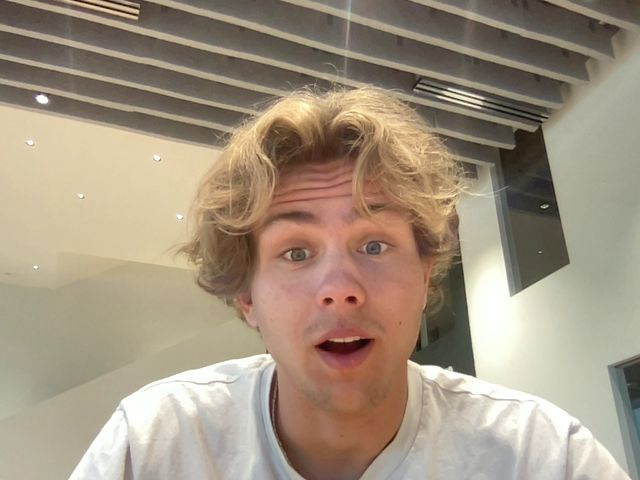

Photo saved as photo_sad.jpg


In [ ]:
# Run this function to capture a photo
photo_file = take_photo('photo_sad.jpg')

### Face detection


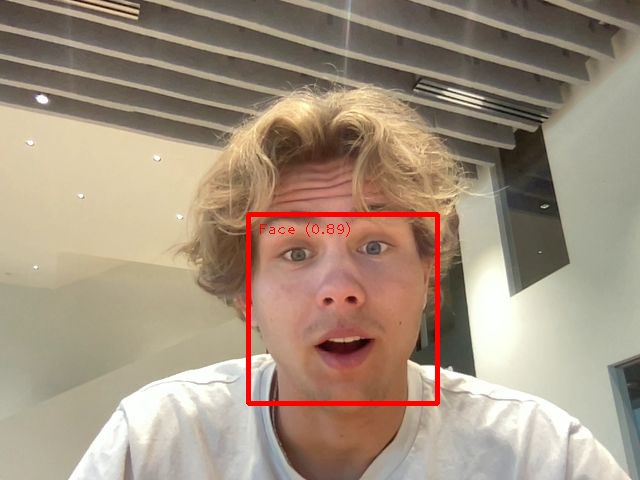

In [ ]:
# Detect the face and check result
image, detection = face_detector(photo_file)
visualize_face_detector(image, detection)

# Crop the face to use for emotion model
cropped_image = crop(image, detection)

### Emotion classify

In [ ]:
# Choose model between 'ViT' and 'CNN

emotion = predict_emotion(cropped_image, model = 'ViT')

Detected emotion:  surprise


### Face transformation

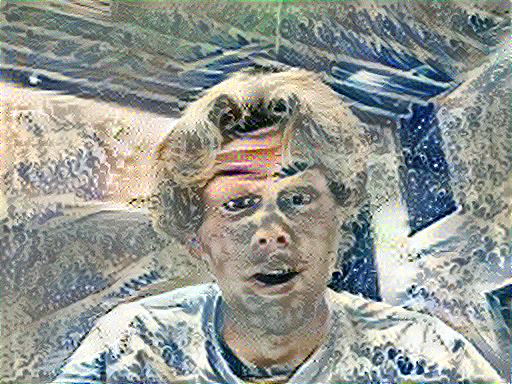

Epoch: 495
Total loss: 1.2481e+06, style loss: 6.6659e+05, content loss: 5.8149e+05, 


In [ ]:
final_image = run_transformation(emotion, photo_file)